# 8. DDPG
之前的章节介绍了基于策略梯度的算法 REINFORCE、Actor-Critic 以及两个改进算法——TRPO 和 PPO。这类算法有一个共同的特点：它们都是在线策略算法，这意味着它们的样本效率（sample efficiency）比较低。我们回忆一下 DQN 算法，DQN 算法直接估计最优函数 Q，可以做到离线策略学习，但是它只能处理动作空间有限的环境，这是因为它需要从所有动作中挑选一个值最大的动作。如果动作个数是无限的，虽然我们可以像 8.3 节一样，将动作空间离散化，但这比较粗糙，无法精细控制。那有没有办法可以用类似的思想来处理动作空间无限的环境并且使用的是离线策略算法呢？本章要讲解的深度确定性策略梯度（deep deterministic policy gradient，DDPG）算法就是如此，它构造一个确定性策略，用梯度上升的方法来最大化值。DDPG 也属于一种 Actor-Critic 算法。我们之前学习的 REINFORCE、TRPO 和 PPO 学习随机性策略，而本章的 DDPG 则学习一个确定性策略。

In [1]:
import random
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # 确保动作在 [-action_bound, action_bound]
        return torch.tanh(self.fc2(x)) * self.action_bound


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        # 输入状态和动作的拼接
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        # 输出一个Q值
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1) # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)   # 输出动作价值对的价值

In [3]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device):
        # 一共有四个网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)

        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        # 目标网络参数缓慢更新 逐渐接近main network
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # target_actor根据下一状态(next_states)选择最优的下一动作(next_actions)
        # target_critic评估在下一状态(next_states)执行最优下一动作(next_actions)的价值
        next_q_values = self.target_critic(next_states, self.target_actor(next_states))

        # 使用贝尔曼方程计算目标Q值。如果任务已结束(dones=1)，则未来价值为0
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        # 计算当前Q值和损失
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # actor根据当前状态(states)输出动作 critic来评估价值
        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

In [9]:
actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 9: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s, episode=200, return=-160.506]


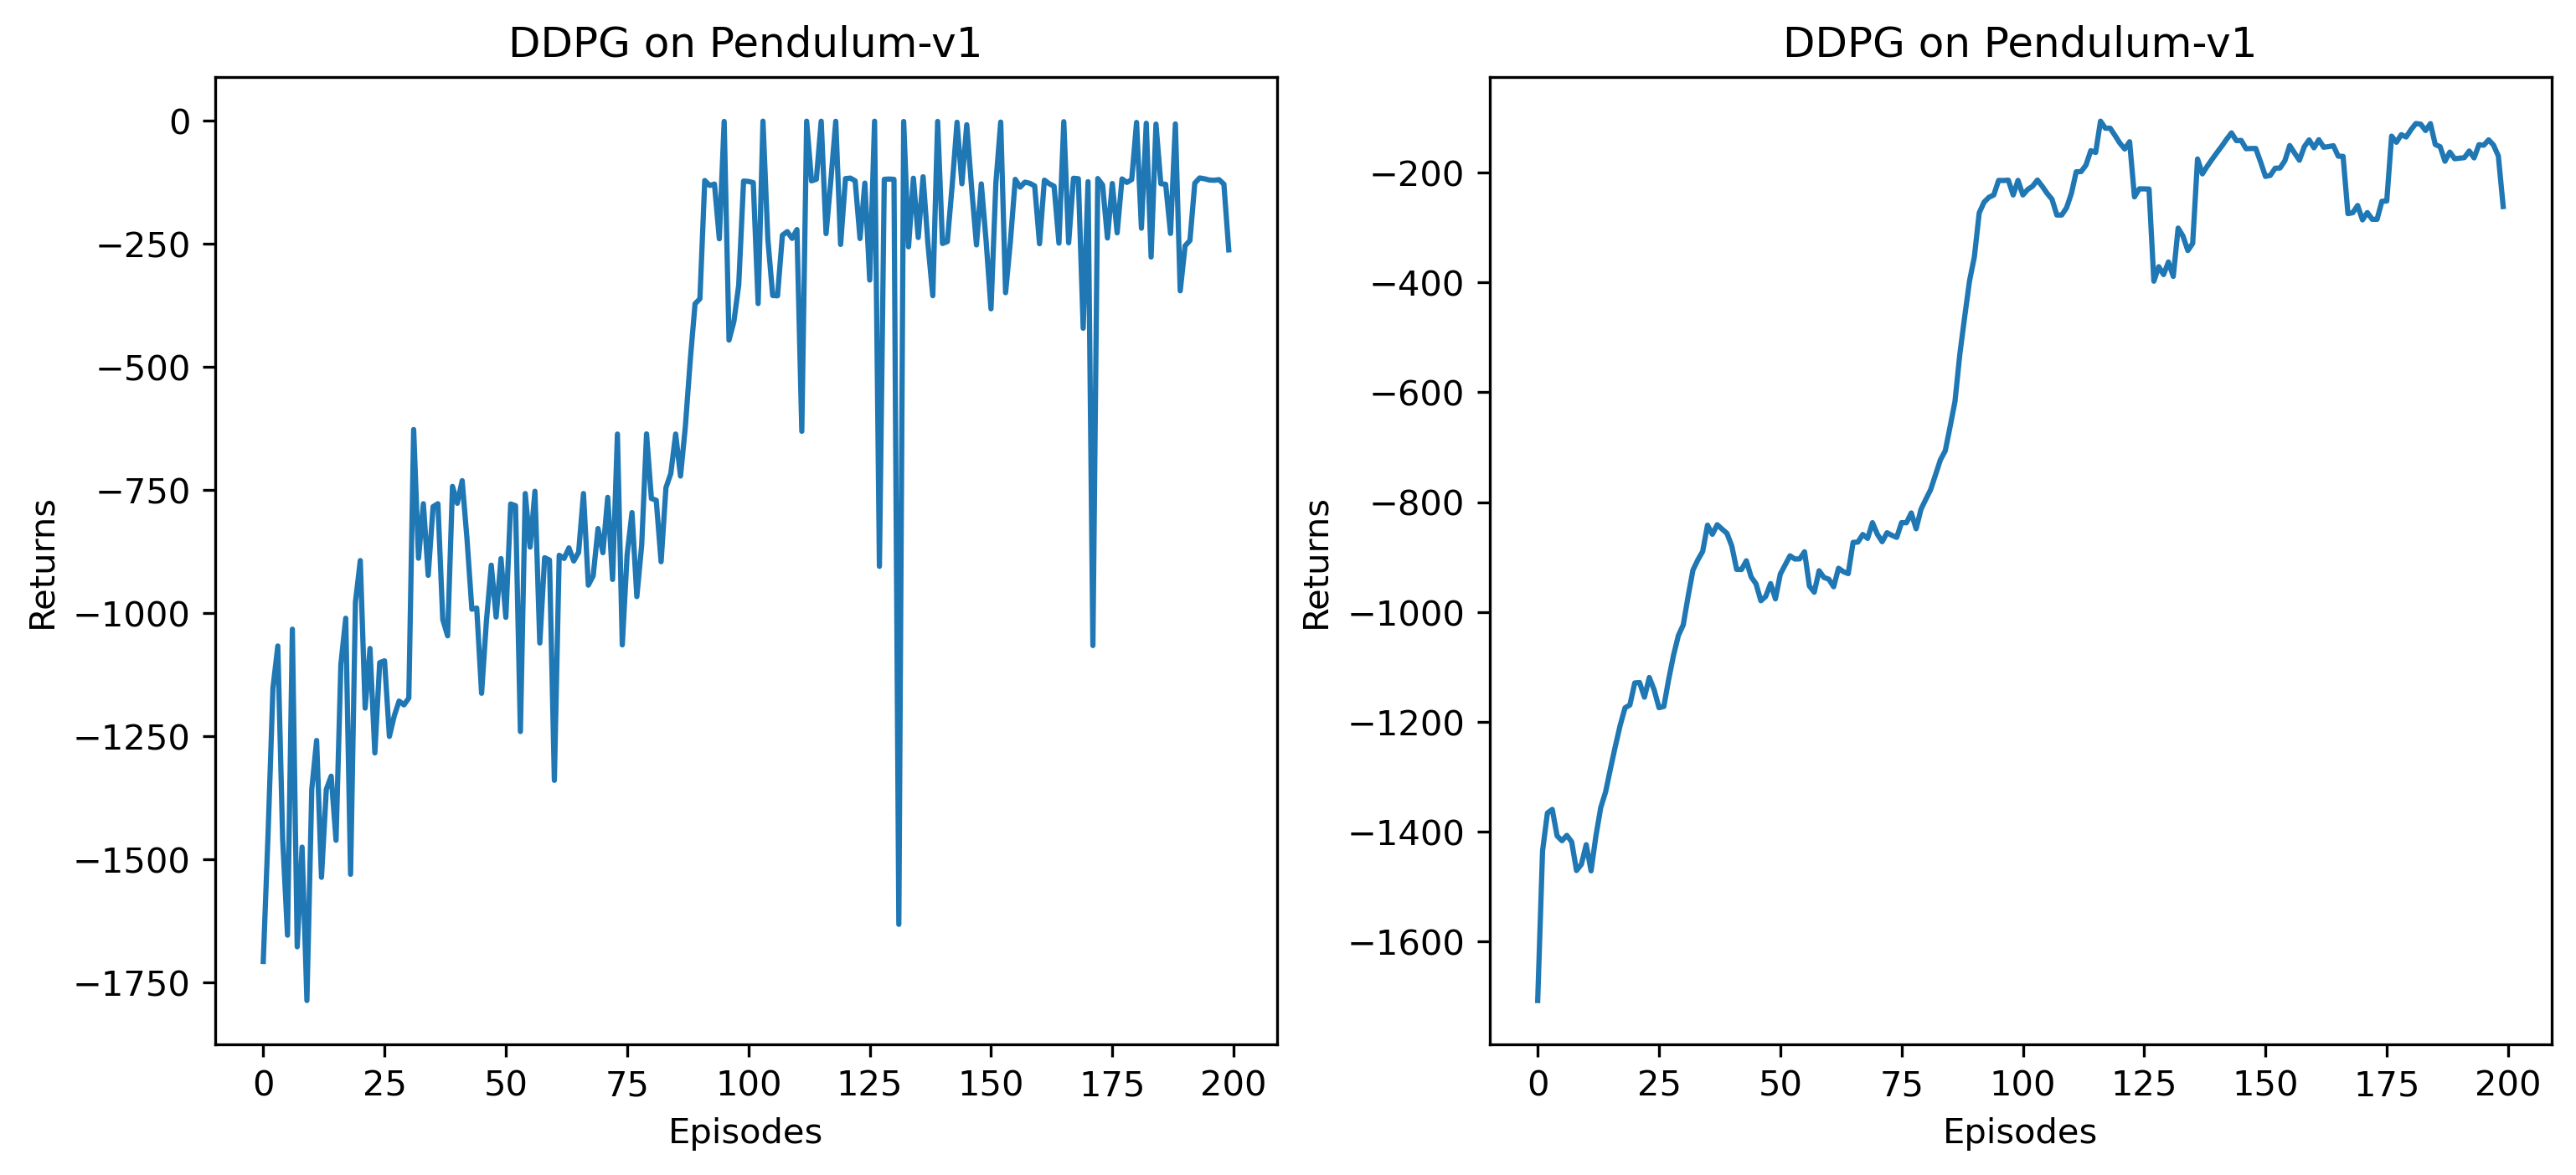

In [10]:
episodes_list = list(range(len(return_list)))
plt.figure(figsize=(12,5), dpi = 300)
plt.subplot(1,2,1)
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))

mv_return = rl_utils.moving_average(return_list, 9)
plt.subplot(1,2,2)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()